# 2. Classifying emotion from call transcripts 

Although using VADER provided the company with a way to see how sentiment changed over the course of each conversation, I thought it would also be useful to have an understanding of specifically which emotions Agents and Borrowers were exhibiting in their conversations. VADER - and most sentiment analysis tools and lexicons - provide sentiment values on a single scale ranging from negative to positive. For the current purposes - identifying good Agent performance, Borrower mood, and potentially aggressive or illegal Agent tactics - having access to a more fine-grained emotion label would be particularly useful.

To this end, I created a coding scheme to capture the different emotions that Borrowers exhibit during their conversations. I labeled these by hand and fed the labels into supervised multinomial models to examine whether a model could be trained to accurately classify turns into emotion categories.

## 2.1. Labeling emotions from call transcript data

## 

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
#reading in the data
corpus = pd.read_csv('/Users/cah/anaconda3/envs/insight/Corpus_processed.csv', low_memory = False)

In [6]:
corpus.head()
corpus2 = corpus

In [7]:
corpus2.head(n = 5)

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount,neg,neu,pos,compound
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12,0.0,0.787,0.213,0.4019
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20,0.0,0.933,0.067,0.0772
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3,0.0,0.208,0.792,0.4215
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1,0.0,0.000,1.000,0.2500
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7,0.0,0.725,0.275,0.2263


In [7]:
corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188010 entries, 0 to 188009
Data columns (total 10 columns):
order         188010 non-null int64
test_train    188010 non-null object
callID        188010 non-null object
index         188010 non-null int64
speaker       188010 non-null object
startTime     188010 non-null object
endTime       188010 non-null float64
transcript    188010 non-null object
emotion       560 non-null object
wordcount     188010 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.3+ MB


In [8]:
corpus2['transcript_strip'] = corpus2['transcript'].str.strip()
corpus2['speaker_cat'] = corpus2['speaker'].astype('category')
#corpus2.speaker_cat.cat.codes

In [9]:
corpus2.head()

,order,test_train,callID,index,speaker,startTime,endTime,transcript,emotion,wordcount,transcript_strip,speaker_cat
0,0,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,0,Agent,1.26,4.24,those recovery minutes name you thomas speakin...,NaN,12,those recovery minutes name you thomas speakin...,Agent
1,1,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,1,Borrower,4.74,13.68,hi angela this is katie the phone number one e...,NaN,20,hi angela this is katie the phone number one e...,Borrower
2,2,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,2,Agent,15.43,17.05,four worth okay,NaN,3,four worth okay,Agent
3,3,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,3,Borrower,16.13,16.63,alright,NaN,1,alright,Borrower
4,4,Test,0a2c3d67-c0f7-4abb-831a-86009e29c5d2,4,Borrower,17.74,22.87,this it's i you get submit okay,NaN,7,this it's i you get submit okay,Borrower


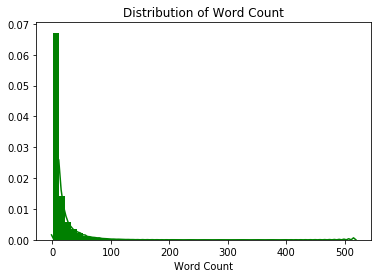

In [10]:
#word count distribution plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(corpus2['wordcount'], color='green', hist_kws=dict(alpha=1))
plt.xlabel('Word Count')
plt.title('Distribution of Word Count')
plt.show()

In [11]:
#eliminating cells that had excess words
corpus_sub = corpus2[corpus2['wordcount'] < 50]

In [12]:
#focusing just on the two columns of interest - transcript_strip and emotion
#getting rid of all null values
from io import StringIO

col = ['transcript_strip', 'emotion']
corpus3 = corpus2[col]
corpus3 = corpus3[pd.notnull(corpus3['transcript_strip'])]
corpus3 = corpus3[pd.notnull(corpus3['emotion'])]


corpus3.columns = ['transcript_strip', 'emotion']

corpus3['category_id'] = corpus3['emotion'].factorize()[0]
category_id_corpus3 = corpus3[['emotion', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_corpus3.values)
id_to_category = dict(category_id_corpus3[['category_id', 'emotion']].values)

corpus3.head()

,transcript_strip,emotion,category_id
282,alright thank you,polite,0
425,i could do it as perfect if you could split it up,no emotion,1
599,alright thanks,polite,0
981,alright thank you so much for holding this is ...,polite,0
1956,alright thank you so much,polite,0


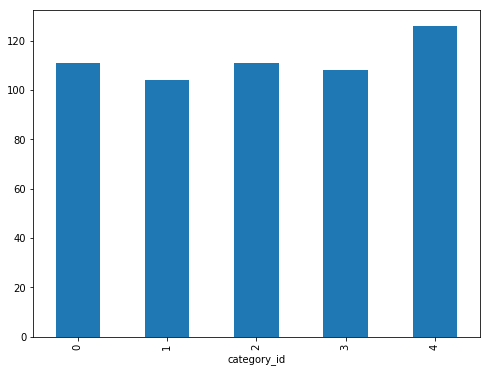

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
corpus3.groupby('category_id').transcript_strip.count().plot.bar(ylim=0)
plt.show()

In [14]:
#now each of the 560 transcript narratives is represented by 171 features representing the tf-idf score for different unigram and bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(corpus3.transcript_strip).toarray()
labels = corpus3.category_id
features.shape

(560, 171)

In [15]:
#find the terms more correlated w each of the emotion labels
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for emotion, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(emotion))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'angry':
  . Most correlated unigrams:
. number
. fucking
  . Most correlated bigrams:
. just broke
. broke law
# 'avoidant':
  . Most correlated unigrams:
. pay
. money
  . Most correlated bigrams:
. money right
. don money
# 'confused':
  . Most correlated unigrams:
. sorry
. company
  . Most correlated bigrams:
. alright thanks
. alright thank
# 'no emotion':
  . Most correlated unigrams:
. yes
. okay
  . Most correlated bigrams:
. alright thanks
. alright thank
# 'polite':
  . Most correlated unigrams:
. thank
. alright
  . Most correlated bigrams:
. alright thanks
. alright thank


In [16]:
#fitting models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(corpus3['transcript_strip'], corpus3['emotion'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [19]:
print(clf.predict(count_vect.transform(["can't pay"])))

['avoidant']


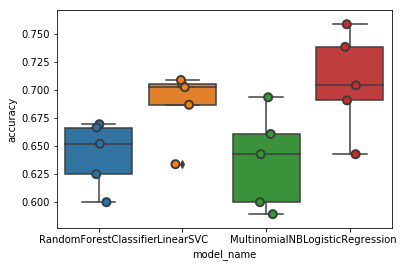

In [35]:
#bench marking 4 models - logistic regression, multinomial naive bayes, linear support vector machine, random forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.687607
LogisticRegression        0.707156
MultinomialNB             0.637341
RandomForestClassifier    0.642697
Name: accuracy, dtype: float64

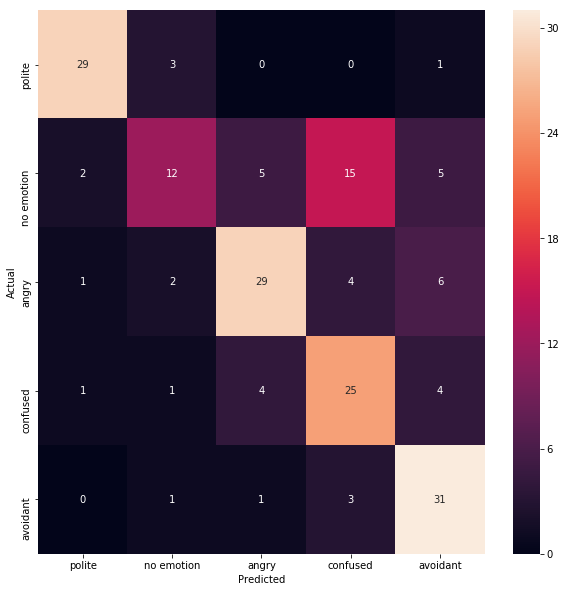

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus3.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_corpus3.emotion.values, yticklabels=category_id_corpus3.emotion.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
from IPython.display import display
for predicted in category_id_corpus3.category_id:
  for actual in category_id_corpus3.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 5:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(corpus3.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['emotion', 'transcript_strip']])
      print('')

'no emotion' predicted as 'angry' : 5 examples.


,emotion,transcript_strip
37319,no emotion,yeah thank tomorrow just calling me tomorrow a...
37416,no emotion,my name ann i you called
37402,no emotion,nothing has been recorded record your message ...
37309,no emotion,how do your pronounce that on just told me for...
37287,no emotion,all just calling into interrupted



'no emotion' predicted as 'confused' : 15 examples.


,emotion,transcript_strip
168685,no emotion,a employed on delivery
37293,no emotion,button
37399,no emotion,if that's an action for getting that perfect
37395,no emotion,from what now
119651,no emotion,about my account
169348,no emotion,amy what's your last night
52067,no emotion,a
67688,no emotion,a little bit
425,no emotion,i could do it as perfect if you could split it up
91255,no emotion,and what is a budget program



'no emotion' predicted as 'avoidant' : 5 examples.


,emotion,transcript_strip
166882,no emotion,actually it's the second friday of june
37455,no emotion,oh okay okay maybe that's right i don't know i...
57411,no emotion,actually
37411,no emotion,who you looking for
37344,no emotion,is what no i don't sure don't he have a cell b...



'angry' predicted as 'avoidant' : 6 examples.


,emotion,transcript_strip
167741,angry,am pissed because if consolidated yeah i wanna...
40349,angry,now i want to have money back i hold on lying ...
66312,angry,okay first of all i talked to somebody yesterd...
20023,angry,because i i get unit kelly my is i just annoyi...
35910,angry,or just tell me what it about all this is actu...
67559,angry,an email because bullshit like this happened i...


In [37]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'angry':
  . Top unigrams:
       . number
       . fucking
  . Top bigrams:
       . just broke
       . broke law
# 'avoidant':
  . Top unigrams:
       . money
       . pay
  . Top bigrams:
       . don money
       . money right
# 'confused':
  . Top unigrams:
       . company
       . does
  . Top bigrams:
       . don know
       . dollars month
# 'no emotion':
  . Top unigrams:
       . okay
       . yes
  . Top bigrams:
       . right don
       . dollars month
# 'polite':
  . Top unigrams:
       . thank
       . appreciate
  . Top bigrams:
       . alright thank
       . alright thanks


In [32]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=corpus3['emotion'].unique()))

              precision    recall  f1-score   support

      polite       0.88      0.88      0.88        33
  no emotion       0.63      0.31      0.41        39
       angry       0.74      0.69      0.72        42
    confused       0.53      0.71      0.61        35
    avoidant       0.66      0.86      0.75        36

   micro avg       0.68      0.68      0.68       185
   macro avg       0.69      0.69      0.67       185
weighted avg       0.69      0.68      0.67       185



In [101]:
#save model after training
#import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [103]:
#When you need to load it:
#model = open('model.pkl','rb')
#model = joblib.load(model)

In [33]:
result = model.score(X_test, y_test)

In [34]:
print(result)

0.7837837837837838
